In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import h5py
import time

In [2]:
def MomentumModulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def TransverseMomentumModulus(px, py):
    return np.sqrt(px**2 + py**2)

In [3]:
inputMC = 'data/LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

tickMC = time.perf_counter()
df_reco = pd.read_hdf(inputMC, key='LHCbMC_Lb')
tockMC = time.perf_counter()
print(f"Monte Carlo imported in {tockMC - tickMC:0.4f} seconds.")

tickMCTruth = time.perf_counter()
df_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_Lb')
tockMCTruth = time.perf_counter()
print(f"Monte Carlo Truth imported in {tockMCTruth - tickMCTruth:0.4f} seconds.")

tickMerge = time.perf_counter()
df_MC = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
tockMerge = time.perf_counter()
print(f"Monte Carlo merged in {tockMerge - tickMerge:0.4f} seconds.")
df_MC = df_MC.loc[(df_MC['MC_key'] >= 0) & (df_MC['Rec_key'] >= 0)]

Monte Carlo imported in 24.2598 seconds.
Monte Carlo Truth imported in 225.8266 seconds.
Monte Carlo merged in 4.3925 seconds.


In [4]:
LambdaZCuts = (df_MC['L_ENDVERTEX_Z'] > 5500) & (df_MC['L_ENDVERTEX_Z'] < 8500)
LambdaMCuts = (df_MC['L_M'] > 600) & (df_MC['L_M'] < 1500)
LambdaDiraCuts = (df_MC['L_BPVDIRA'] > 0.9999)
LambdaChi2Cuts = (df_MC['L_BPVIPCHI2'] < 200) & (df_MC['L_BPVVDCHI2'] < 2e7) & (df_MC['L_VFASPF_CHI2_VDOF'] < 750)
LambdaPCuts = (TransverseMomentumModulus(df_MC['L_PX'], df_MC['L_PY']) > 450)

LambdabMCuts = (df_MC['Lb_M'] < 8500)
LambdabDiraCuts = (df_MC['Lb_BPVDIRA'] > 0.99) | (df_MC['Lb_BPVDIRA'] < -0.99)
LambdabChi2Cuts = (df_MC['Lb_BPVIPCHI2'] < 1750) & (df_MC['Lb_VFASPF_CHI2_VDOF'] < 150)

ProtonPCuts = (MomentumModulus(df_MC['p_PX'], df_MC['p_PY'], df_MC['p_PZ']) > 10000) & (TransverseMomentumModulus(df_MC['p_PX'], df_MC['p_PY']) > 400)
PionPCuts = (MomentumModulus(df_MC['pim_PX'], df_MC['pim_PY'], df_MC['pim_PZ']) > 2000)

df_MC_Filtered = df_MC.loc[(LambdaZCuts) & (LambdaMCuts) & (LambdaDiraCuts) 
                           & (LambdaChi2Cuts) & (LambdabMCuts) & (LambdabDiraCuts) & (LambdabChi2Cuts)
                           & (ProtonPCuts) & (PionPCuts)]

# The Bump
This notebook is dedicated to the study of the following "bump" of events in the $\Lambda$ decay vertex $\Delta z := z - z^\text{true}$ distribution.

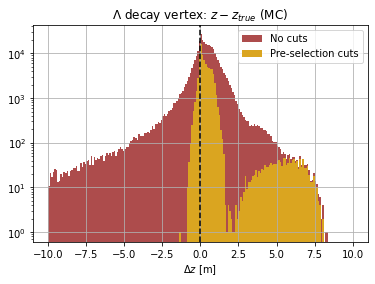

In [50]:
plt.hist((df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         range=(-10,10), bins=200, color='darkred',alpha=0.7, label='No cuts')
plt.hist((df_MC_Filtered['L_ENDVERTEX_Z'] - df_MC_Filtered['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         range=(-10,10), bins=200, color='goldenrod', label='Pre-selection cuts')
plt.axvline(0,0,100,color='k', linestyle='--')
plt.grid()
plt.yscale('log')
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ (MC)')
plt.xlabel('$\Delta z$ [m]')
plt.legend()
#plt.savefig("plots/lambda_endvertex/LEVz_MC_true-residuals.pdf", bbox_inches = "tight")
plt.show()

They are not as impactful as they might seem (log scale means the bump only comes from a little over 1300 events), but still worth a study to try and understand where they come from.

In [8]:
bumpMin = 2500
bumpMax = max(df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'])

df_MC_Bump = df_MC_Filtered.loc[(df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'] > bumpMin) 
                                & (df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'] < bumpMax)]
df_MC_Bump

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
83,0.3591,0.5208,54.601398,-7.069900,3.450100,207.821304,-2133.159912,839.080017,47703.500000,-462.730011,...,168.644516,8050.427246,-877.465881,2949.704102,28659.386719,503.071472,542.181152,34615.269531,T,2161
322,0.9811,-0.1064,-10.373100,39.110401,-9.633700,892.385681,2256.040039,-580.280029,53323.429688,373.010010,...,11.394564,9777.557617,245.647934,-661.962646,6534.991699,214.789459,2318.685303,79123.320312,T,7154
481,1.8740,-0.5979,-7.037500,77.090500,9.801200,2603.591553,2191.830078,419.899994,75441.242188,326.279999,...,105.792328,10330.285156,4723.738770,-1085.751831,94738.843750,4505.037598,-4013.477539,156311.734375,T,10886
1171,0.1414,1.5671,53.120602,-40.854801,62.156700,1629.196167,-2788.929932,4230.279785,109229.312500,-197.470001,...,301.166901,8386.341797,1261.195801,625.372681,19754.654297,-1252.327026,2551.658936,73733.820312,T,28281
1321,-0.0331,0.4286,-29.150000,-23.548599,19.783300,1213.161255,-1286.079956,1014.260010,59612.480469,-243.539993,...,375.111206,19825.923828,-2780.458984,1261.912231,29981.962891,693.816040,-195.606369,12767.225586,T,32475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365234,0.9957,-0.0362,49.869701,2.975700,-5.118500,106.211601,1218.489990,-3061.919922,33042.980469,64.919998,...,-425.455841,4497.814941,3173.299316,-249.295761,60930.140625,1169.239014,-1852.048828,20070.611328,T,8893825
365253,1.4299,0.6050,117.518204,14.881200,52.732899,2314.522705,662.049988,2310.320068,104164.593750,124.930000,...,288.674194,10983.095703,2651.343994,-1007.890991,147194.484375,152.971527,1337.366577,75120.367188,T,8894276
365389,0.8186,1.1129,-85.156197,-2.836800,20.834801,187.319000,-637.640015,3580.209961,49682.750000,-155.529999,...,1343.604370,16515.082031,-907.808167,1879.470337,15091.293945,1829.309448,694.547363,21186.083984,T,8897814


## Distribution and dependence on $z$

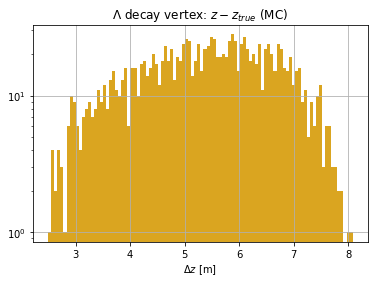

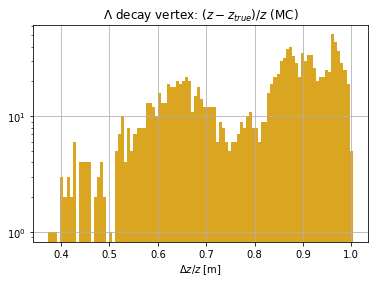

In [46]:
plt.hist((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         bins=100, color='goldenrod', label='Pre-selection cuts')
plt.grid()
plt.yscale('log')
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ (MC)')
plt.xlabel('$\Delta z$ [m]')
#plt.legend()
plt.show()

plt.hist((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/df_MC_Bump['L_ENDVERTEX_Z'],
         bins=100, color='goldenrod', label='Pre-selection cuts')
plt.grid()
plt.yscale('log')
plt.title('$\Lambda$ decay vertex: $(z-z_{true})/z$ (MC)')
plt.xlabel('$\Delta z / z$ [m]')
#plt.legend()
plt.show()

In [ ]:
plt.hist((df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         range=(-10,10), bins=200, color='darkred',alpha=0.7, label='No cuts')
plt.hist((df_MC_Filtered['L_ENDVERTEX_Z'] - df_MC_Filtered['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         range=(-10,10), bins=200, color='goldenrod', label='Pre-selection cuts')
plt.axvline(0,0,100,color='k', linestyle='--')
plt.grid()
plt.yscale('log')
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ (MC)')
plt.xlabel('$\Delta z$ [m]')
plt.legend()
plt.savefig("plots/lambda_endvertex/LEVz_MC_true-residuals.pdf", bbox_inches = "tight")
plt.show()

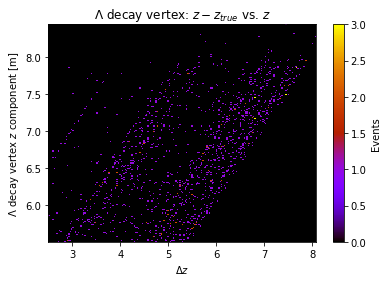

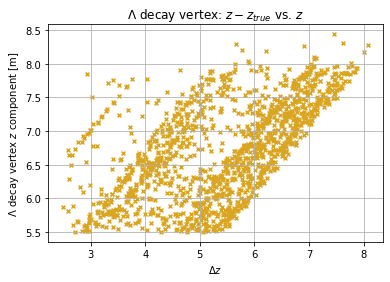

In [45]:
plt.hist2d((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/1000,
           df_MC_Bump['L_ENDVERTEX_Z']/1000,
           bins=200, cmap='gnuplot')
plt.xlabel('$\Delta z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ vs. $z$')
plt.colorbar(label='Events')
plt.show()

plt.scatter((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/1000,
           df_MC_Bump['L_ENDVERTEX_Z']/1000,
           marker='x', s=15, color='goldenrod')
plt.xlabel('$\Delta z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ vs. $z$')
plt.grid()
plt.show()

Visible substructures of $\Delta z$ as a function of $z$. While one can expect a general $z - z^\text{true} \propto z$ dependence, it would seem that the Bump is triggered by specific values of $z^\text{true}$ (i.e. specific vertical intercepts).

By contrast, here is how the same plots look when all filtered events are taken into account.

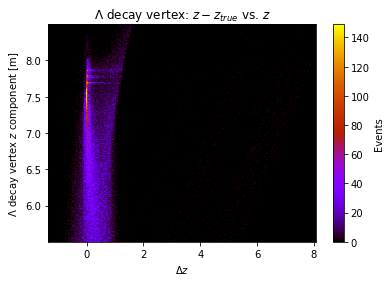

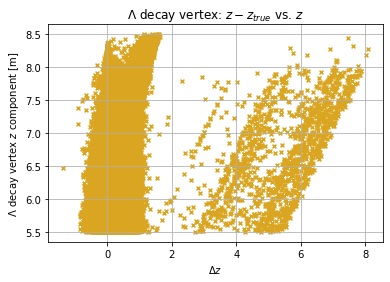

In [78]:
plt.hist2d((df_MC_Filtered['L_ENDVERTEX_Z'] - df_MC_Filtered['MCTRUTH_L_ENDVERTEX_Z'])/1000,
           df_MC_Filtered['L_ENDVERTEX_Z']/1000,
           bins=200, cmap='gnuplot')
plt.xlabel('$\Delta z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ vs. $z$')
plt.colorbar(label='Events')
plt.show()

plt.scatter((df_MC_Filtered['L_ENDVERTEX_Z'] - df_MC_Filtered['MCTRUTH_L_ENDVERTEX_Z'])/1000,
           df_MC_Filtered['L_ENDVERTEX_Z']/1000,
           marker='x', s=15, color='goldenrod')
plt.xlabel('$\Delta z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ vs. $z$')
plt.grid()
plt.show()

(Squint your eyes a little, the lines are still there in the 2D histogram. They're just very faint.)

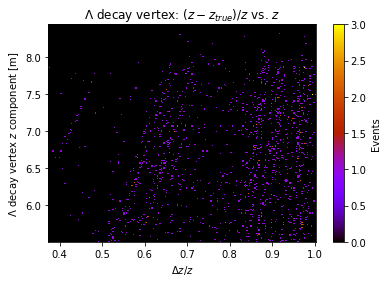

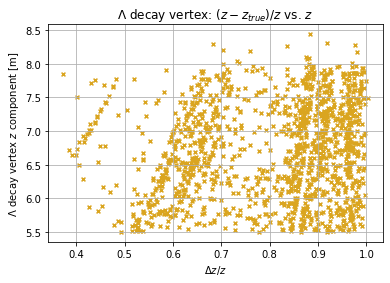

In [28]:
plt.hist2d((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/df_MC_Bump['L_ENDVERTEX_Z'],
           df_MC_Bump['L_ENDVERTEX_Z']/1000,
           bins=200, cmap='gnuplot')
plt.xlabel('$\Delta z / z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $(z-z_{true})/z$ vs. $z$')
plt.colorbar(label='Events')
plt.show()

plt.scatter((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/df_MC_Bump['L_ENDVERTEX_Z'],
           df_MC_Bump['L_ENDVERTEX_Z']/1000,
           marker='x', s=15, color='goldenrod')
plt.xlabel('$\Delta z / z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $(z-z_{true})/z$ vs. $z$')
plt.grid()
plt.show()

## Event distribution in the detector

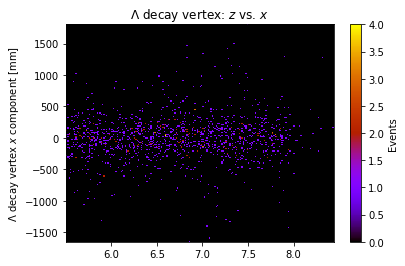

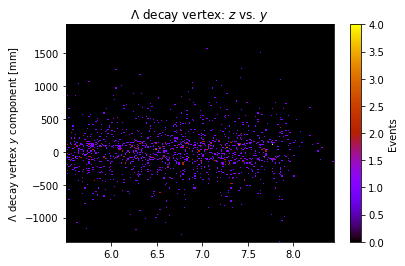

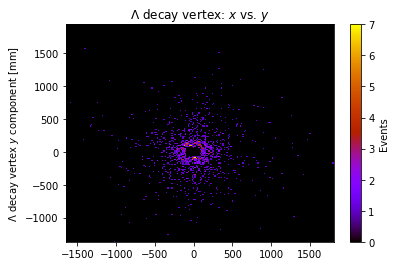

In [41]:
plt.hist2d(df_MC_Bump['L_ENDVERTEX_Z']/1000, df_MC_Bump['L_ENDVERTEX_X'],
           bins=200, cmap='gnuplot')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $x$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z$ vs. $x$')
plt.colorbar(label='Events')
plt.show()

plt.hist2d(df_MC_Bump['L_ENDVERTEX_Z']/1000, df_MC_Bump['L_ENDVERTEX_Y'],
           bins=200, cmap='gnuplot')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $y$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z$ vs. $y$')
plt.colorbar(label='Events')
plt.show()

plt.hist2d(df_MC_Bump['L_ENDVERTEX_X'], df_MC_Bump['L_ENDVERTEX_Y'],
           bins=200, cmap='gnuplot')
plt.ylabel("$\Lambda$ decay vertex $x$ component [mm]")
plt.ylabel("$\Lambda$ decay vertex $y$ component [mm]")
plt.title('$\Lambda$ decay vertex: $x$ vs. $y$')
plt.colorbar(label='Events')
plt.show()

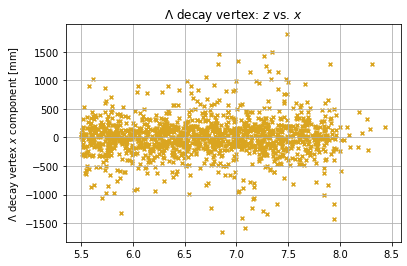

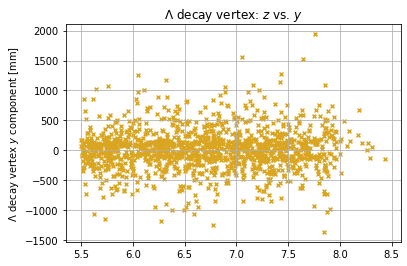

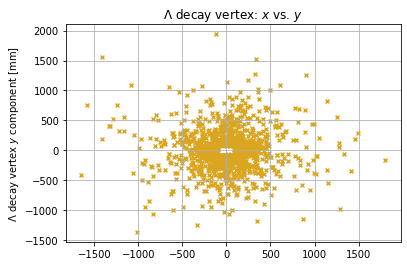

In [38]:
plt.scatter(df_MC_Bump['L_ENDVERTEX_Z']/1000, df_MC_Bump['L_ENDVERTEX_X'],
           marker='x', s=15, color='goldenrod')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $x$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z$ vs. $x$')
plt.grid()
plt.show()

plt.scatter(df_MC_Bump['L_ENDVERTEX_Z']/1000, df_MC_Bump['L_ENDVERTEX_Y'],
           marker='x', s=15, color='goldenrod')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $y$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z$ vs. $y$')
plt.grid()
plt.show()

plt.scatter(df_MC_Bump['L_ENDVERTEX_X'], df_MC_Bump['L_ENDVERTEX_Y'],
           marker='x', s=15, color='goldenrod')
plt.ylabel("$\Lambda$ decay vertex $x$ component [mm]")
plt.ylabel("$\Lambda$ decay vertex $y$ component [mm]")
plt.title('$\Lambda$ decay vertex: $x$ vs. $y$')
plt.grid()
plt.show()

There seems to be no discernible origin for these events in the detector. No easy cut, I'm afraid.

## Miscellaneous checks

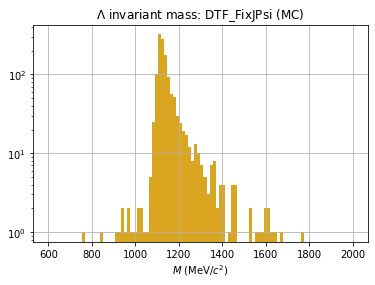

In [55]:
plt.hist(df_MC_Bump['DTF_FixJPsi_L_M'],bins=100,
         range=(600,2000), color='goldenrod', alpha=1, label="Pre-selection cuts", density=False)
plt.grid()
plt.yscale('log')
plt.xlabel("$M$ (MeV/$c^2$)")
plt.title("$\Lambda$ invariant mass: DTF_FixJPsi (MC)")
#plt.savefig("plots/lambda_invariant-mass/LIM_DTF-FixJPsi_MC.pdf", bbox_inches = "tight")
plt.show()

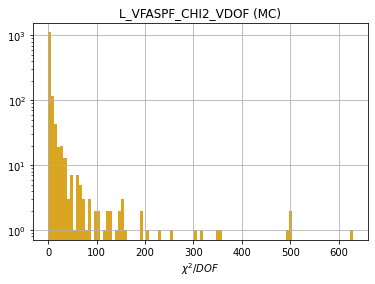

In [56]:
plt.hist(df_MC_Bump['L_VFASPF_CHI2_VDOF'], bins=100,
         color='goldenrod', label="Pre-selection cuts", alpha=1)
plt.yscale('log')
plt.grid()
plt.title("L_VFASPF_CHI2_VDOF (MC)")
plt.xlabel("$\chi^2 / DOF$")
#plt.savefig("plots/lambda_vertex-fit/LVF_VFASPF_CHI2_VDOF_MC.pdf", bbox_inches = "tight")
plt.show()